In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

In [2]:
P_THRESHOLD=0.5

### read in data

In [3]:
DATADIR = os.getenv('DATADIR')

In [4]:
print("model v2.0.0 was run on data dated {}".format(DATADIR))

model v2.0.0 was run on data dated /data/2018-03-12


In [5]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)# Create World taxon in case any items not identified 
# through doc type in clean_content are still present
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

# creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

# Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

# create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labelled_level2['level2taxon_code']),
                        labelled_level2['level2taxon']))

In [6]:
labelled_level2.taxon_id.nunique()

2552

In [7]:
new_pred = pd.read_csv(
    os.path.join(DATADIR, 'level1_predictions_1726_1203_.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [8]:
new_content = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level1.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [9]:
new_content.shape

(15984, 31)

In [10]:
new_arrays = np.load(os.path.join(DATADIR, 'level1_arrays.npz'))

In [11]:
new_arrays.files

['x', 'meta', 'title', 'desc', 'content_id']

In [12]:
new_arrays['content_id'].shape

(15984,)

### combine data

In [13]:
if new_arrays['content_id'].shape[0] == new_pred.shape[0]:
    new_pred['content_id'] = new_arrays['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")
    
    

In [14]:
new_pred['content_id'].nunique()

14919

In [15]:
newprob_by_id = pd.melt(new_pred, 
                        id_vars=['content_id'], var_name='taxon2', value_name='prob')

In [23]:
newprob_by_id.shape

(3484512, 4)

In [24]:
#convert from string to numeric
newprob_by_id['prob'] = pd.to_numeric(newprob_by_id['prob'])
newprob_by_id['taxon2'] = pd.to_numeric(newprob_by_id['taxon2'])

In [25]:
#get the label for the level2 taxon code
newprob_by_id['taxon2label'] = newprob_by_id['taxon2'].map(labels_index)

In [56]:
newprob_meta = pd.merge(
    left=newprob_by_id,
    right=new_content,
    on='content_id',
    how='left',
    indicator=True, 
    validate='m:m'
)

In [27]:
newprob_meta.columns

Index(['content_id', 'taxon2', 'prob', 'taxon2label', 'base_path',
       'content_purpose_document_supertype', 'content_purpose_subgroup',
       'content_purpose_supergroup', 'description', 'details', 'document_type',
       'email_document_supertype', 'first_published_at',
       'government_document_supertype', 'locale',
       'navigation_document_supertype', 'public_updated_at', 'publishing_app',
       'search_user_need_document_supertype', 'title', 'updated_at',
       'user_journey_document_supertype', 'document_type_gp',
       'primary_publishing_organisation', 'body', 'combined_text', 'taxon_id',
       'taxon_base_path', 'taxon_name', 'level1taxon', 'level2taxon',
       'level3taxon', 'level4taxon', 'level5taxon', '_merge'],
      dtype='object')

#### drop content ids which are really taxons

In [28]:
#drop taxons document type. Why are these here? Shoudl be cleaned in create_new?
newprob_meta = newprob_meta[newprob_meta['document_type']!='taxon']

In [29]:
newprob_meta.shape

(3964984, 35)

In [30]:
newprob_meta.content_id.nunique()

14919

### count content items

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2c755e6a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa2a82b92b0>]], dtype=object)

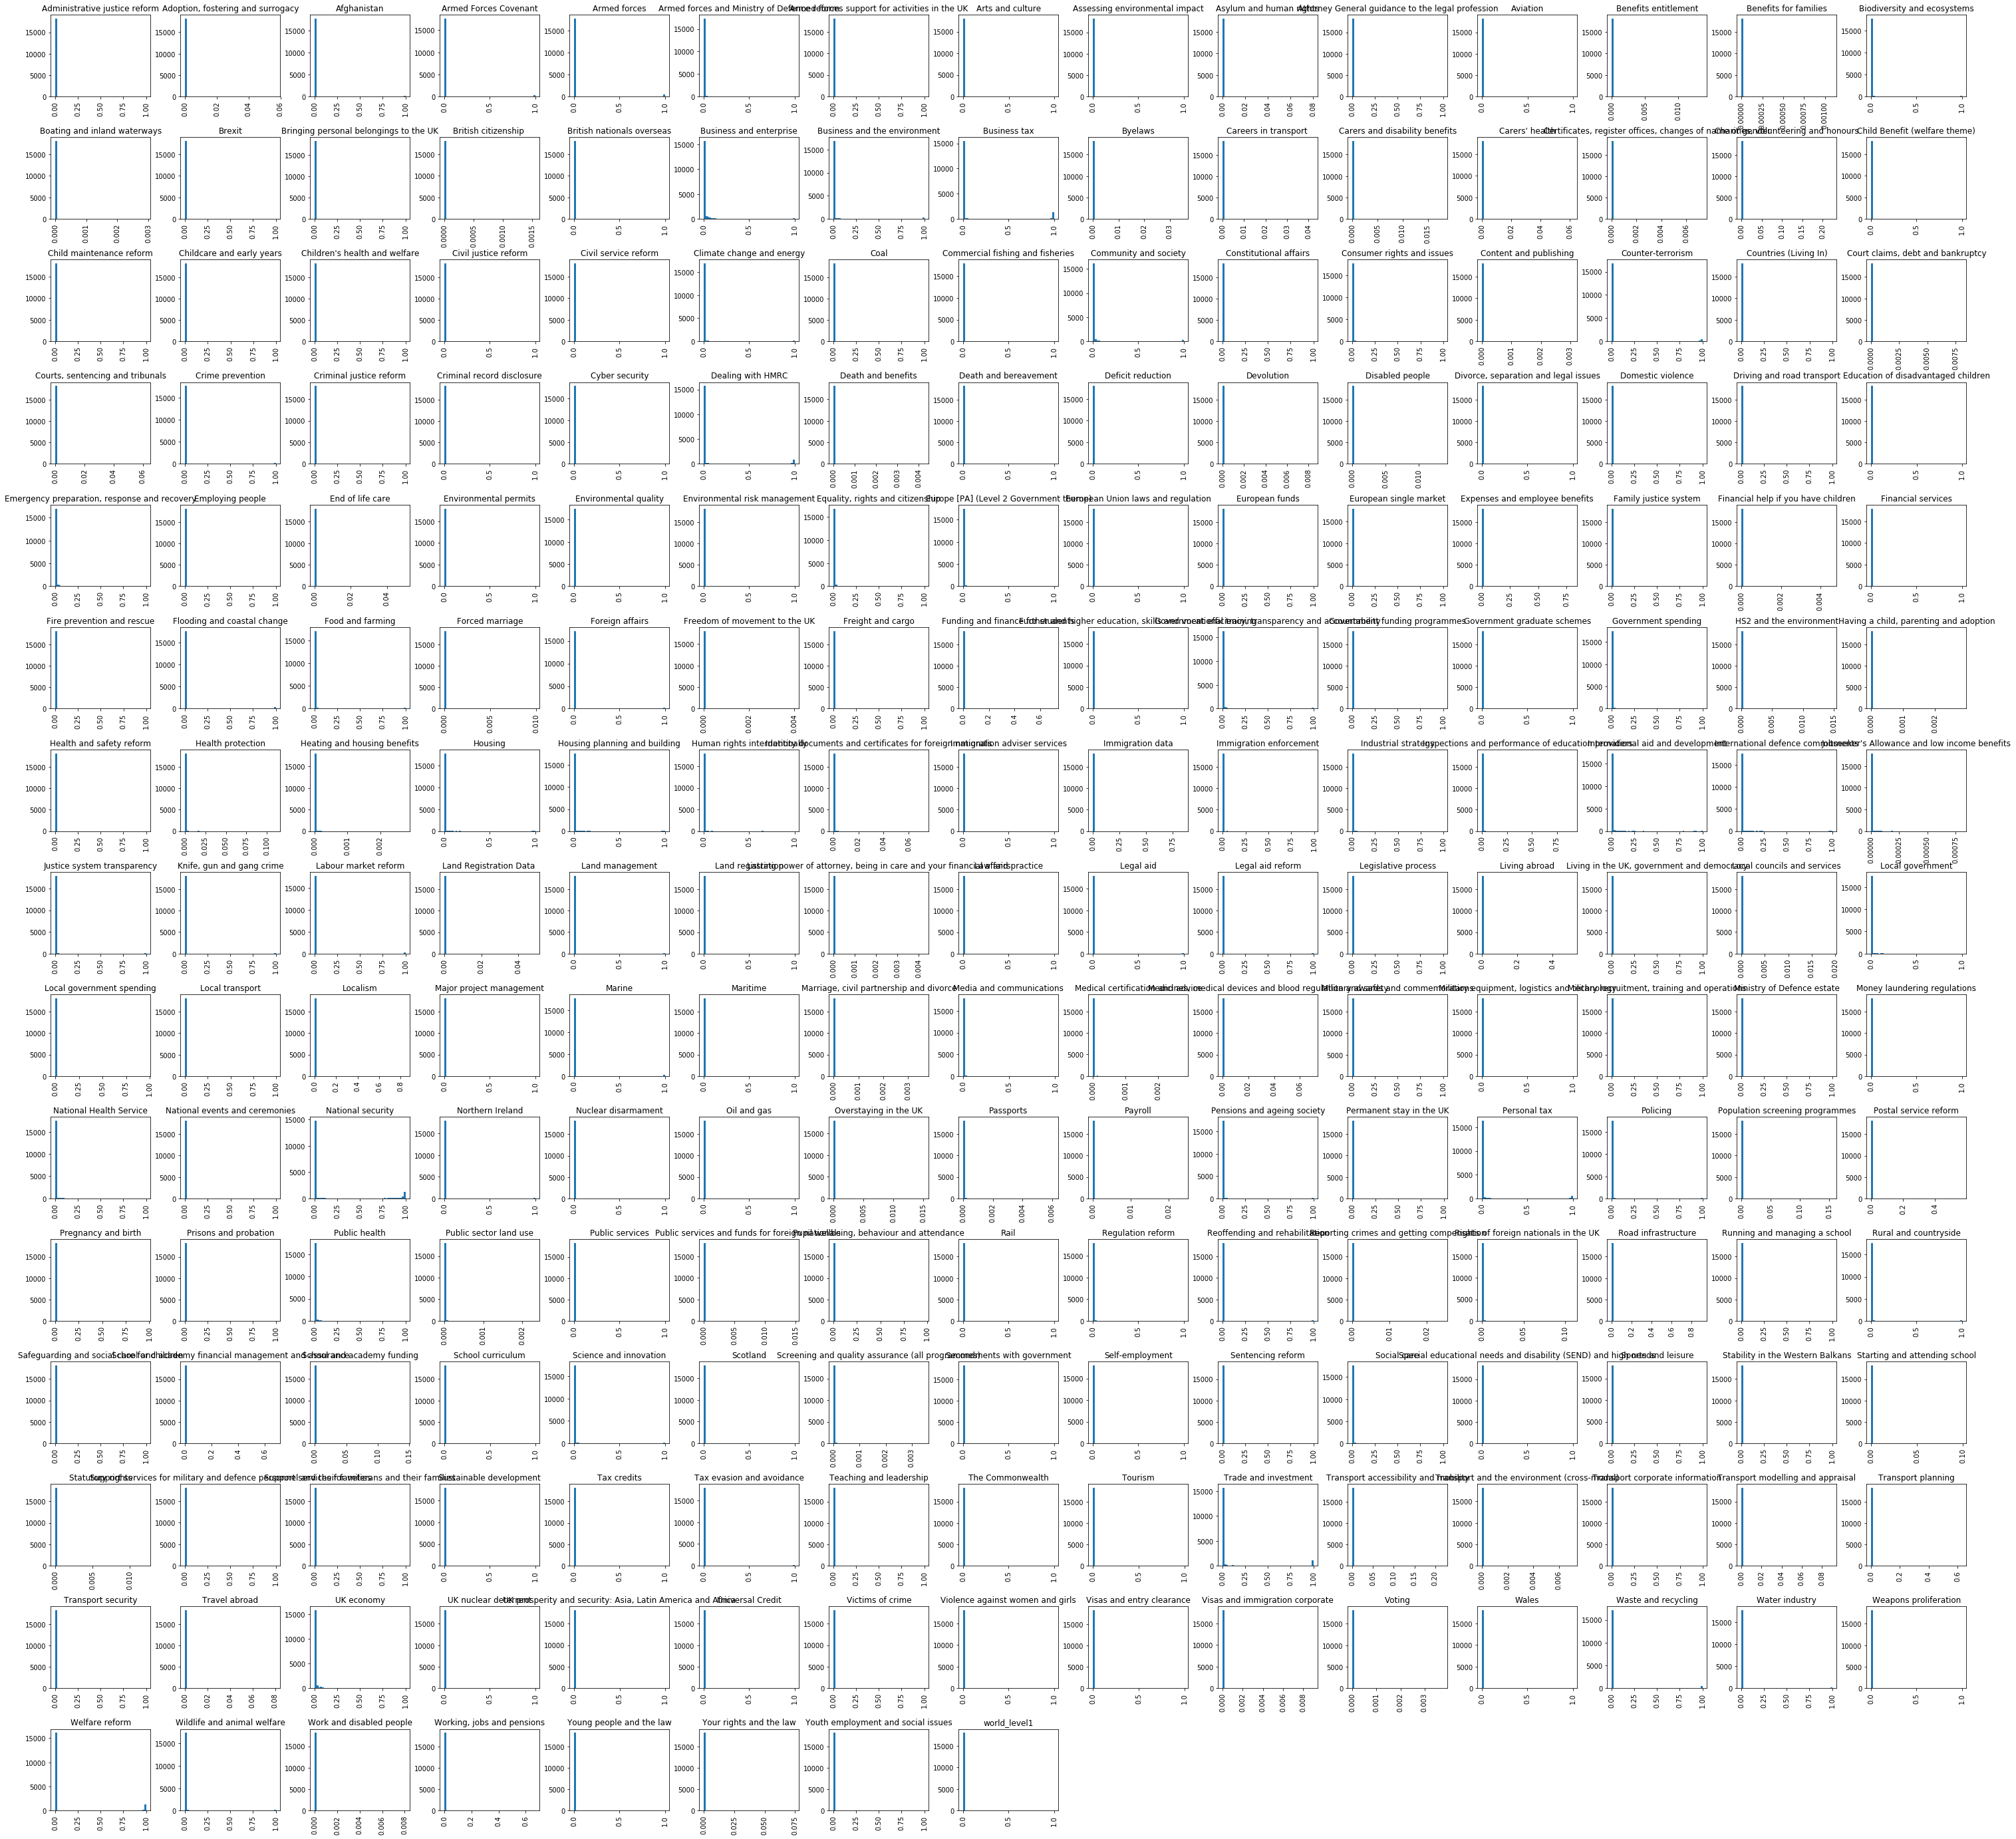

In [33]:
newprob_meta['prob'].hist(by=newprob_meta['taxon2label'], figsize=(50, 50), bins=50)

In [34]:
newprob_meta[newprob_meta['prob']<0.01].shape

(3894302, 35)

In [35]:
newprob_meta[newprob_meta['prob']<0.01].shape[0]/newprob_meta.shape[0]

0.9821734463493421

In [36]:
atleast1pct = newprob_meta[newprob_meta['prob']>=0.01]
atleast1pct.shape

(70682, 35)

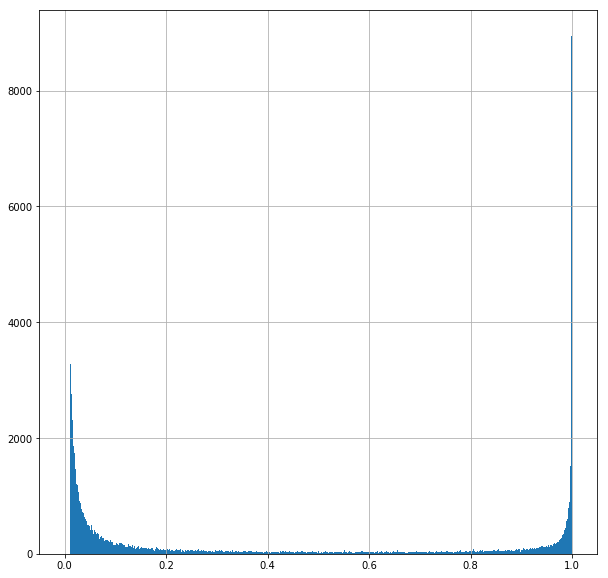

In [40]:
atleast1pct['prob'].hist(range=(0, 1), figsize=(10, 10), bins=500)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa296ff1390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa2942dd6a0>]], dtype=object)

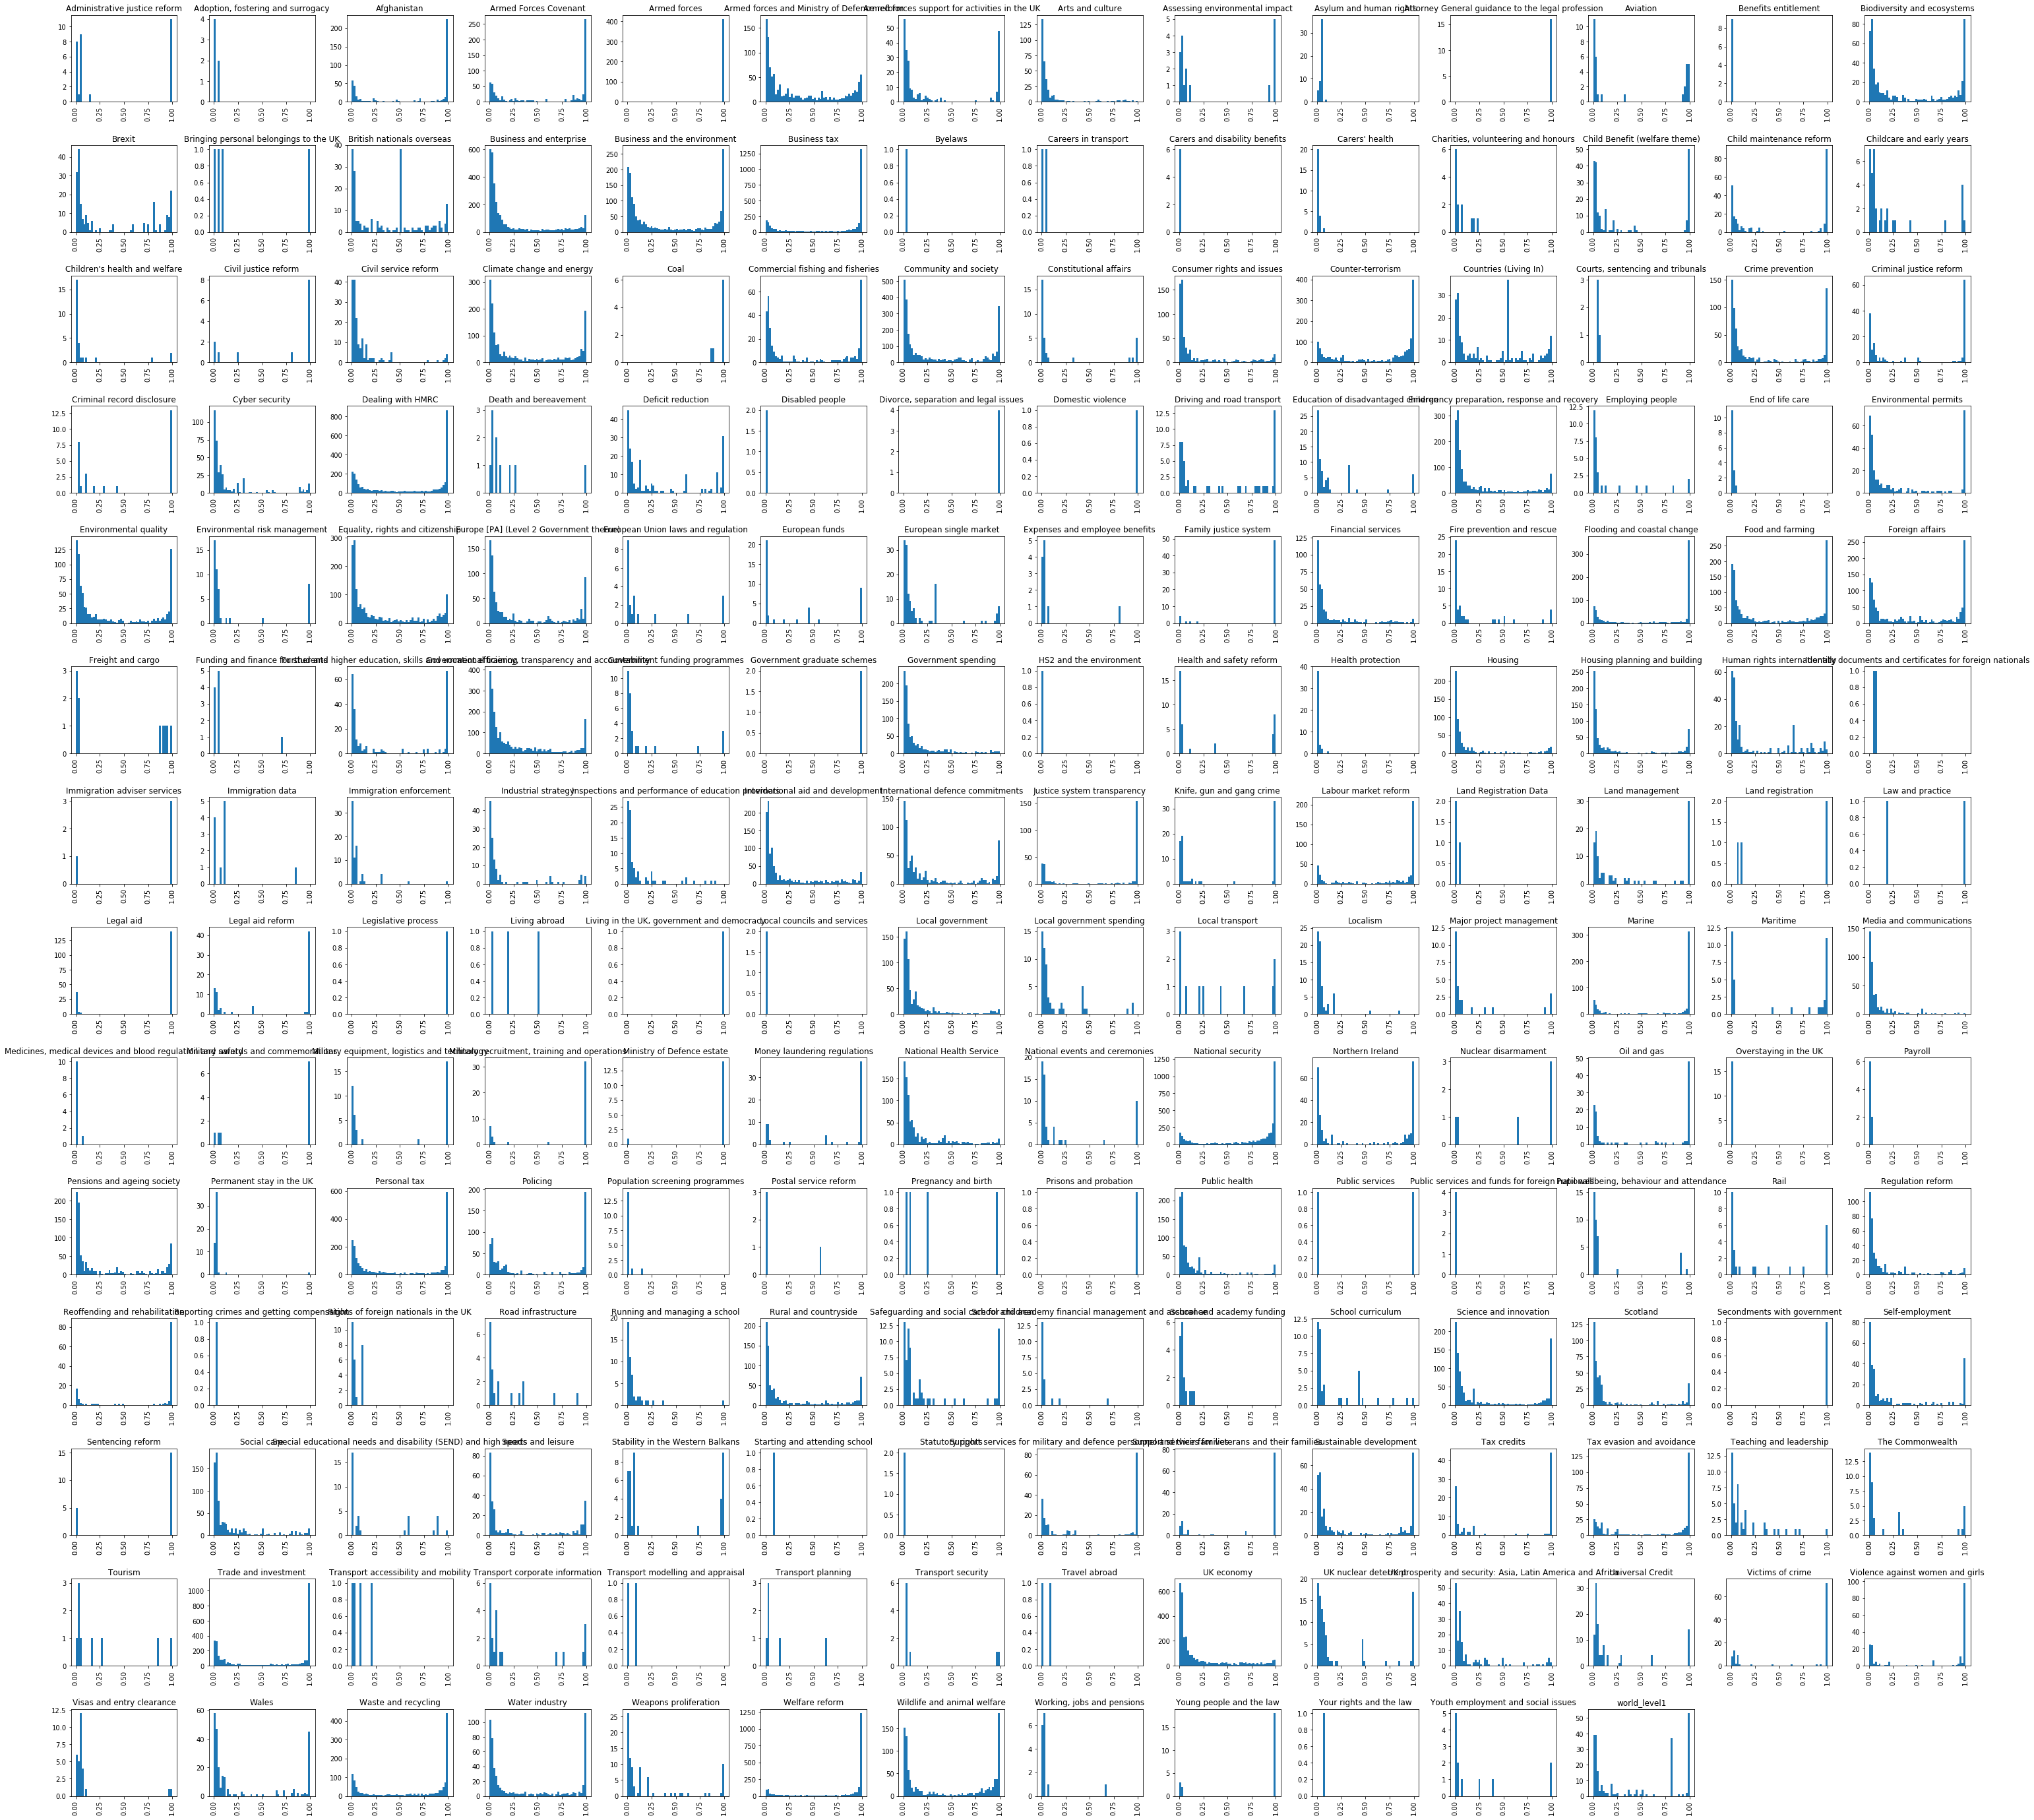

In [41]:
#TODO: work out how to standardise ylim to 0, 3000 
atleast1pct['prob'].hist(by=atleast1pct['taxon2label'], range=(0, 1), figsize=(50, 50), bins=50)

In [42]:
predictions = newprob_meta[newprob_meta['prob'] > 0.5]

In [43]:
predictions['content_id'].nunique()

14300

In [45]:
predictions['content_id'].nunique()/newprob_meta['content_id'].nunique()

0.9585092834640392

In [44]:
predictions.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    14300.000000
mean         1.915175
std          2.334292
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        108.000000
dtype: float64

In [62]:
labelled_level2.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    123900.000000
mean          1.391001
std           0.778077
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          35.000000
dtype: float64

In [47]:
predictions[['prob', 'taxon2label', 'title', 'description', 'level1taxon']][100:150]


,prob,taxon2label,title,description,level1taxon
38824,0.997951,Afghanistan,british forces mentor the next afghan military...,the kmtc is where afghan soldiers receive thei...,Defence
38827,0.997722,Afghanistan,military cross for gurkha hero,a gurkha soldier who ferociously fought off 2 ...,Defence
38829,0.997428,Afghanistan,raf's reaper logs 10 000 hours over afghanistan,the raf's reaper programme has achieved the mi...,Defence
38832,0.999249,Afghanistan,rmp prepare for afghan investigations,royal military police (rmp) are being put thro...,Defence
38833,0.999012,Afghanistan,us and royal marines strengthen ties during sa...,british and american marines have built on a r...,Defence
38834,0.999055,Afghanistan,testing raf equipment for operations in afghan...,pilots and engineers at the mod testing statio...,Defence
38835,0.999910,Afghanistan,royal marines hand control of checkpoints to a...,over the last three months a number of checkpo...,Defence
38836,0.993831,Afghanistan,apache pilot reaches 5 000 flying hours,an army air corps (aac) apache pilot with 20 y...,Defence
38837,0.936623,Afghanistan,the outstanding examples of a generation - the...,the national army museum in chelsea hosted the...,Defence
38838,0.999633,Afghanistan,commando chefs keep marines on the go in sangin,working as some of the myriad 'backroom' speci...,Defence


In [48]:
predictions.to_csv(os.path.join(DATADIR, 'level1predictions.csv.gz'),compression='gzip',index=False)

### 40% threshold

In [130]:
predictions40 = newprob_meta[newprob_meta['prob'] > 0.4]

predictions40.content_id.nunique()

predictions40.content_id.nunique()/newprob_meta.content_id.nunique()

0.972317179435619

### HARD to tag

In [57]:
predictions.groupby('_merge').size()

_merge
left_only         0
right_only        0
both          27387
dtype: int64

In [63]:
predictions.drop(labels='_merge', axis=1, inplace=True)

newprob_meta.drop(labels='_merge', axis=1, inplace=True)

In [112]:
no_predictions = pd.merge(
    left=predictions,
    right=newprob_meta,
    on='content_id',
    how='outer',
    indicator=True
)

In [113]:
no_predictions.groupby('_merge').size()

_merge
left_only            0
right_only      182248
both          11984550
dtype: int64

In [114]:
no_predictions = no_predictions[no_predictions['_merge']=='right_only']

In [115]:
no_predictions.shape

(182248, 68)

In [116]:
no_predictions.content_id.nunique()

619

In [117]:
predictions.content_id.nunique()

14300

In [118]:
no_predictions.content_id.nunique() + predictions.content_id.nunique()

14919

In [119]:
newprob_meta.content_id.nunique()

14919

In [120]:
no_predictions = no_predictions[['content_id', 'prob_y', 'taxon2label_y', 'title_y', 'description_y', 'level1taxon_y']].sort_values('prob_y', ascending=False)

In [121]:
no_predictions[(no_predictions['prob_y']<0.5) & (no_predictions['prob_y']>=0.4)].content_id.nunique()

206

In [127]:
no_predictions[(no_predictions['prob_y']<0.4) & (no_predictions['prob_y']>=0.3)].content_id.nunique()

224

In [123]:
no_predictions[(no_predictions['prob_y']<0.3) & (no_predictions['prob_y']>=0.2)]['content_id'].nunique()

294

In [124]:
no_predictions[(no_predictions['prob_y']<0.2) & (no_predictions['prob_y']>=0.1)]['content_id'].nunique()

391

In [125]:
no_predictions[(no_predictions['prob_y']<0.1) ]['content_id'].nunique()

619

In [126]:
no_predictions.to_csv(os.path.join(DATADIR, 'level1_hardtotag50.csv.gz'),compression='gzip',index=False)